## Objective

1. Given data for the last N days of ETF pricing data, this model aims to predict for the N + H days in the future
2. Utilizing Prophet & LSTM as models to forecast time-series data

In [26]:
import pandas as pd
import numpy as np
import time
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from fbprophet import Prophet

In [2]:
# reading the dataset
# 5 years worth of pricing data
df = pd.read_csv('SPY.csv')

# convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

# remove spaces in col headers
df.columns = [str(i).lower().replace(' ','_') for i in df.columns]

# sort values by datetime
df.sort_values(by = 'date', inplace = True, ascending = True)

df.head()

,date,open,high,low,close,adj_close,volume
0,2015-06-15,208.639999,209.449997,207.789993,209.110001,189.227280,124384200
1,2015-06-16,208.929993,210.350006,208.720001,210.250000,190.258896,85308200
2,2015-06-17,210.589996,211.320007,209.360001,210.589996,190.566559,126708600
3,2015-06-18,211.309998,213.339996,210.630005,212.779999,192.548340,165867900
4,2015-06-19,211.460007,211.550003,210.360001,210.809998,191.693558,130478700


Text(0, 0.5, 'USD')

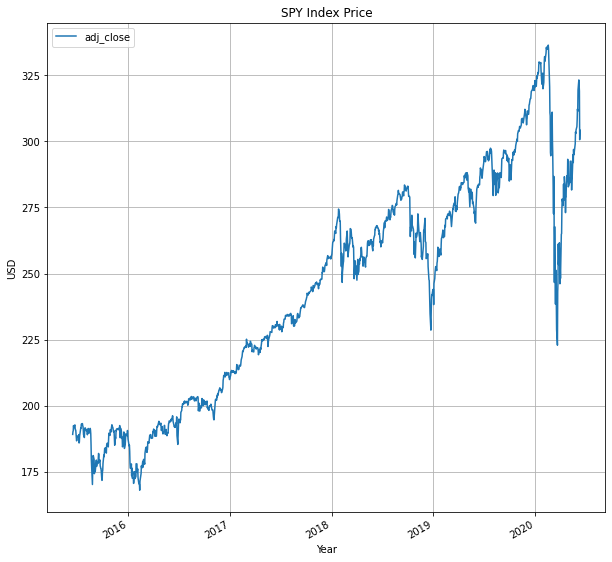

In [3]:
# Plot adjusted closing price of ETF over time
plt = df.plot(x = 'date', y = 'adj_close', linestyle='-', figsize = [10,10], grid = True)
plt.set_title('SPY Index Price')
plt.set_xlabel('Year')
plt.set_ylabel('USD')

In [4]:
# Create new dataframe for Prophet
# Prophet always takes in 2 columns only, DS & Y
df_prophet = df[['date', 'adj_close']].rename(columns = {'date':'ds', 'adj_close':'y'})
df_prophet.tail()

,ds,y
1254,2020-06-08,323.200012
1255,2020-06-09,320.790009
1256,2020-06-10,319.000000
1257,2020-06-11,300.609985
1258,2020-06-12,304.209991


In [5]:
# based on historical data, we want to predict prices for the next 30 days, which will be the forecast horizon
H = 30

# 4 years of data to be training set
# typical year has around 253 trading days
train_size = 253*4

# 1 year to be validation set
test_size = 253

# size of both sets
train_test_size = train_size + test_size

In [6]:
# Fitting Prophet model
m = Prophet()
m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
# Create new dataframe with dates we want to predict
future = m.make_future_dataframe(periods = H)

In [10]:
# remove weekends from future dataframe, since we do not need to predict weekend data
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.weekday.html
# https://facebook.github.io/prophet/docs/non-daily_data.html

future['day'] = future['ds'].dt.weekday
future = future[future['day'] <5]

forecast = m.predict(future)

In [11]:
# check if we have values for future predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1274,2020-07-06,299.920586,288.663317,312.418097
1275,2020-07-07,300.550740,288.152384,313.567903
1276,2020-07-08,300.707556,288.730758,313.403250
1277,2020-07-09,301.050752,289.371982,314.080900
1278,2020-07-10,301.360097,289.016460,314.309717


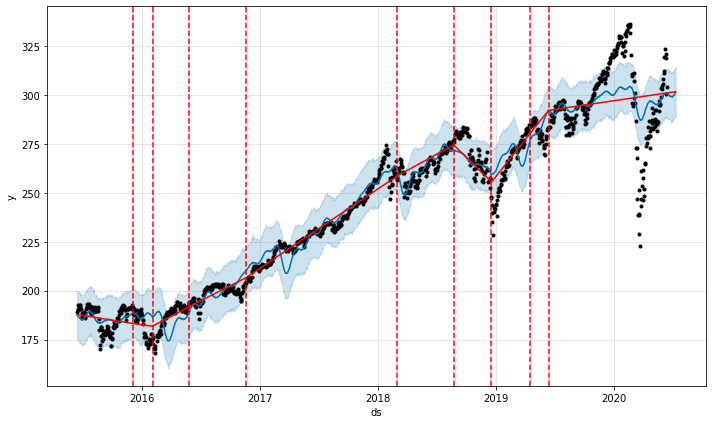

In [21]:
# plot the forecast
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast);

# add changepoints
a = add_changepoints_to_plot(fig.gca(), m, forecast)

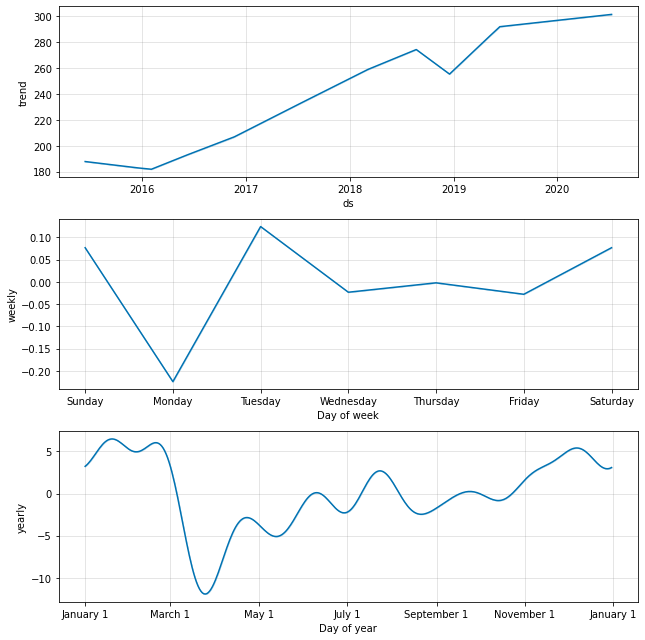

In [22]:
# plot components
m.plot_components(forecast);

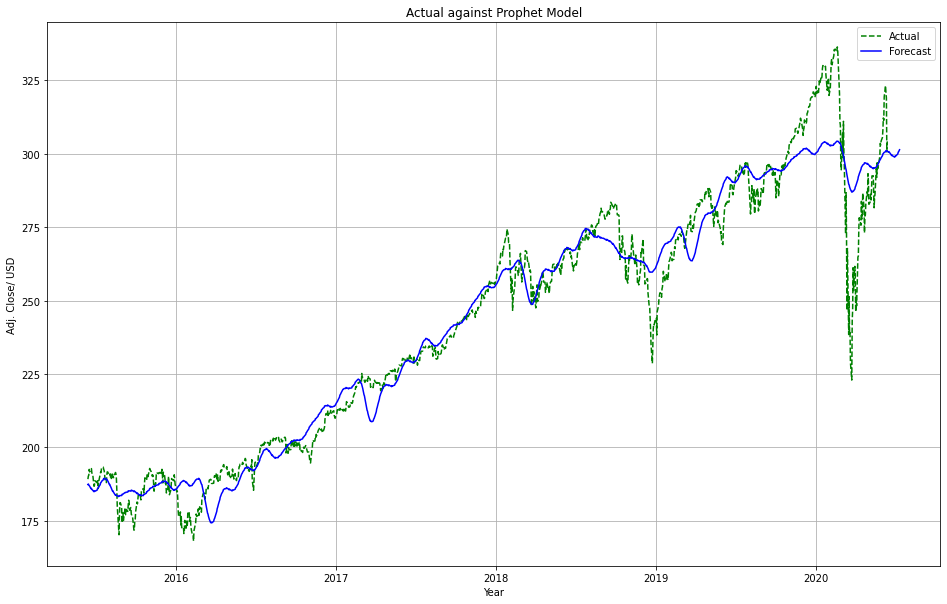

In [16]:
# Plotting the acutal plot against the forecast
plt.rcParams["figure.figsize"] = [16,10]
fig, ax = plt.subplots()
ax.plot('date','adj_close', linestyle='--', color='g', data = df)
ax.plot('ds', 'yhat', linestyle='-', color='b', data = forecast)

ax.set_title('Actual against Prophet Model')
ax.legend(['Actual','Forecast'])
ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Adj. Close/ USD')
ax.grid(True)
plt.show()

## Tweaking the model

From the plot above, the forecasted model does generally follow the acutal data, but we want to improve the prediction accuracy of the Prophet model to get a more reliable forecast of future values. 

In [17]:
# Evaluating accuracy of time series model with error metrics 
# Use these metrics to evaluate our prediction accuracy

# MAPE - mean absolute percentage error
def get_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE - mean absolute error
def get_mae(x, y):
    return np.mean(abs(np.array(x)-np.array(y)))

# RMSE - root mean squared error
def get_rmse(x, y):
    return math.sqrt(np.mean((np.array(x)-np.array(y))**2))

In [18]:
# Compare original dataframe and forecast model
print("MAPE: " + str(get_mape(df['adj_close'], forecast['yhat'][:-20])) + '\n' +
      "MAE: " + str(get_mae(df['adj_close'], forecast['yhat'][:-20])) + '\n' +
      "RMSE: " + str(get_rmse(df['adj_close'], forecast['yhat'][:-20]))
)

MAPE: 2.694284813514794
MAE: 6.558316223460894
RMSE: 9.664222949035862


# Resources on what to tune in Prophet
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

In [24]:
# Count the total possible models that can arrive from the various model tuning parameters
# Parameters such as mode of seasonality, fourier order, the number of changepoints and their scale

from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'fourier_order':[1 , 2, 3, 4, 5],
               'changepoint_prior_scale':[0.05, 0.1, 0.5, 1, 1.5, 2],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
count = 0
for p in grid:
    count = count+1

print('Total Possible Models',count)

Total Possible Models 180


In [32]:
# Prophet model tuning
model_parameters = pd.DataFrame(columns = ['MAPE', 'MAE', 'RMSE', 'Parameters'])

start = time.time()
counter = 0

for p in tqdm(grid):
    random.seed(10)
    m = Prophet(seasonality_mode = p['seasonality_mode'],
                          changepoint_prior_scale = p['changepoint_prior_scale'],
                          n_changepoints = p['n_changepoints'],
                          daily_seasonality = True,
                          weekly_seasonality = True,
                          yearly_seasonality = True, 
                          interval_width = 0.95)
    
    #iterate through fourier_order
    m.add_seasonality(name='monthly', period=H, fourier_order= int(p['fourier_order']))
                
    # fit our Prophet-ready dataframe
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods = H)
    
    # remove weekends from our dataframe
    future['day'] = future['ds'].dt.weekday
    future = future[future['day'] <5]
    forecast = m.predict(future)
    
    # compute error metrics
    MAPE = get_mape(df['adj_close'], forecast['yhat'][:-20])
    MAE = get_mae(df['adj_close'], forecast['yhat'][:-20])
    RMSE = get_rmse(df['adj_close'], forecast['yhat'][:-20])
    
    # increase counter
    counter +=1    
    model_parameters = model_parameters.append({'MAPE':MAPE, 'MAE':MAE, 'RMSE':RMSE, 'Parameters':p}, 
                                               ignore_index=True)
    
end = time.time()
print("Time taken:" + end-start)

100%|██████████| 180/180 [1:14:23<00:00, 24.80s/it]


TypeError: can only concatenate str (not "float") to str

In [33]:
# Export results to CSV
model_parameters.to_csv('tuning_results.csv')

# Sort parameters by descending MAPE
model_parameters.sort_values(by = ['MAPE', 'MAE', 'RMSE'])

# Model 148 provides the best results
grid[147]

{'seasonality_mode': 'additive',
 'n_changepoints': 150,
 'fourier_order': 5,
 'changepoint_prior_scale': 1.5}

In [39]:
# Train final model with parameters
final_model = Prophet(seasonality_mode='additive', n_changepoints= 150, changepoint_prior_scale = 1.5)
final_model.add_seasonality(name='monthly', period=H, fourier_order= 5)

# Fit final model
final_model.fit(df_prophet)
future = final_model.make_future_dataframe(periods = H)

# remove weekends
future['day'] = future['ds'].dt.weekday
future = future[future['day'] <5]
forecast_final = final_model.predict(future)
forecast_final.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-15,184.723706,183.565462,193.986626,184.723706,184.723706,4.018911,4.018911,4.018911,-0.191863,...,0.724042,0.724042,0.724042,3.486732,3.486732,3.486732,0.0,0.0,0.0,188.742617
1,2015-06-16,184.580179,184.108249,194.025770,184.580179,184.580179,4.506637,4.506637,4.506637,-0.282388,...,0.952540,0.952540,0.952540,3.836485,3.836485,3.836485,0.0,0.0,0.0,189.086815
2,2015-06-17,184.436651,184.237190,194.506243,184.436651,184.436651,4.808631,4.808631,4.808631,-0.389210,...,1.049311,1.049311,1.049311,4.148530,4.148530,4.148530,0.0,0.0,0.0,189.245282
3,2015-06-18,184.293124,184.204658,194.382279,184.293124,184.293124,5.034075,5.034075,5.034075,-0.339252,...,0.948236,0.948236,0.948236,4.425092,4.425092,4.425092,0.0,0.0,0.0,189.327199
4,2015-06-19,184.149596,184.703445,194.714358,184.149596,184.149596,5.474689,5.474689,5.474689,-0.106921,...,0.912758,0.912758,0.912758,4.668852,4.668852,4.668852,0.0,0.0,0.0,189.624285


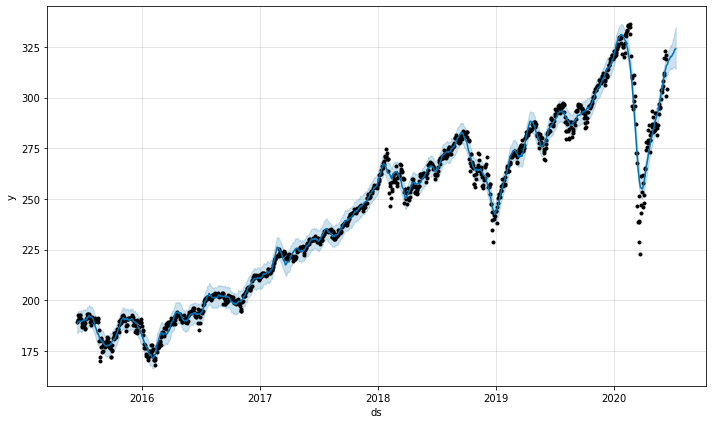

In [40]:
# plot graphs
fig2 = final_model.plot(forecast_final);

In [45]:
# with changepoints
a = add_changepoints_to_plot(fig2.gca(), m, forecast_final)

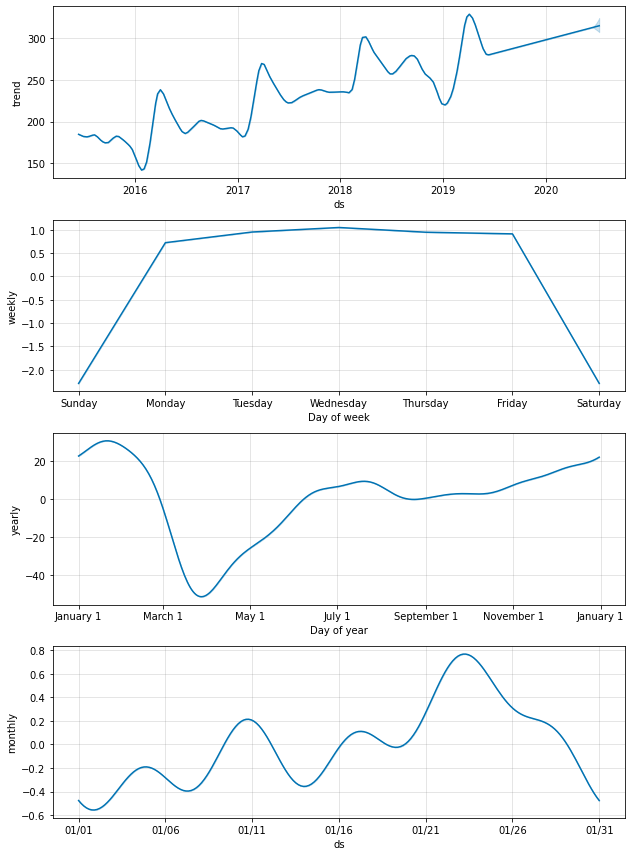

In [43]:
# plot components
final_model.plot_components(forecast_final);

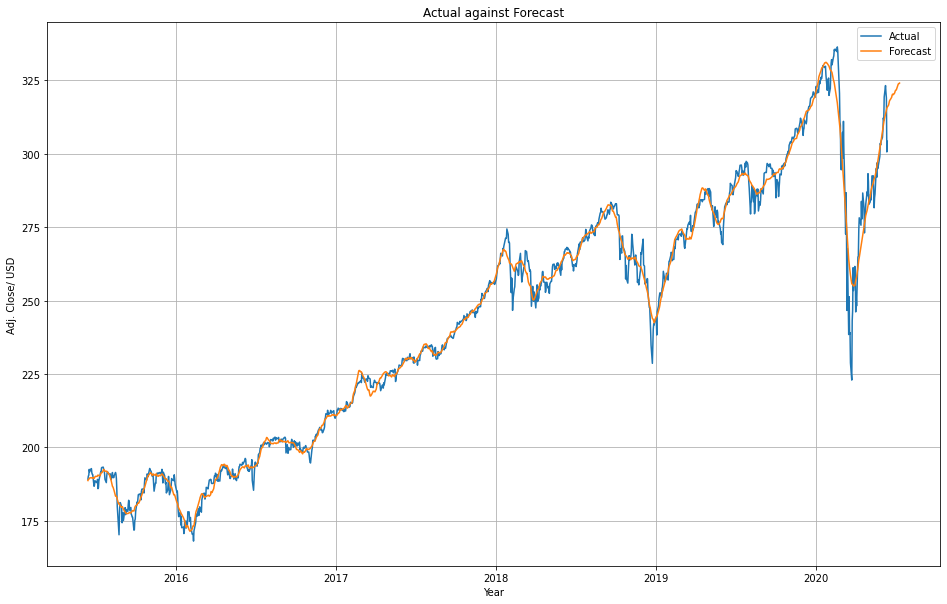

In [46]:
# plotting final model against actual data
plt.rcParams["figure.figsize"] = [16,10]
fig, ax = plt.subplots()
ax.plot('date','adj_close', data = df)
ax.plot('ds', 'yhat', data = forecast_final)

ax.set_title('Actual against Forecast')
ax.legend(['Actual','Forecast'])
ax.xaxis.set_label_text('Year')
ax.yaxis.set_label_text('Adj. Close/ USD')
ax.grid(True)
plt.show()

In [47]:
forecast_final[-H:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1249,2020-06-01,311.377622,302.717594,312.146641,311.377622,311.377622,-3.945715,-3.945715,-3.945715,0.071348,...,0.724042,0.724042,0.724042,-4.741106,-4.741106,-4.741106,0.0,0.0,0.0,307.431907
1250,2020-06-02,311.466298,303.518825,313.792702,311.466298,311.466298,-2.997903,-2.997903,-2.997903,-0.017010,...,0.952540,0.952540,0.952540,-3.933433,-3.933433,-3.933433,0.0,0.0,0.0,308.468395
1251,2020-06-03,311.554975,304.279086,314.290548,311.554975,311.554975,-2.068815,-2.068815,-2.068815,0.026929,...,1.049311,1.049311,1.049311,-3.145056,-3.145056,-3.145056,0.0,0.0,0.0,309.486159
1252,2020-06-04,311.643651,305.720678,315.315966,311.643651,311.643651,-1.161813,-1.161813,-1.161813,0.269681,...,0.948236,0.948236,0.948236,-2.379730,-2.379730,-2.379730,0.0,0.0,0.0,310.481838
1253,2020-06-05,311.732327,306.816552,316.194103,311.732327,311.732327,-0.144689,-0.144689,-0.144689,0.583571,...,0.912758,0.912758,0.912758,-1.641019,-1.641019,-1.641019,0.0,0.0,0.0,311.587638
1254,2020-06-08,311.998357,308.778483,318.697503,311.998357,311.998357,1.603979,1.603979,1.603979,0.495956,...,0.724042,0.724042,0.724042,0.383981,0.383981,0.383981,0.0,0.0,0.0,313.602336
1255,2020-06-09,312.087033,309.109753,319.247420,312.087033,312.087033,2.249227,2.249227,2.249227,0.310071,...,0.952540,0.952540,0.952540,0.986616,0.986616,0.986616,0.0,0.0,0.0,314.336260
1256,2020-06-10,312.175709,310.099685,319.696064,312.175709,312.175709,2.826959,2.826959,2.826959,0.227807,...,1.049311,1.049311,1.049311,1.549841,1.549841,1.549841,0.0,0.0,0.0,315.002669
1257,2020-06-11,312.264386,310.333962,320.544044,312.264386,312.264386,3.197889,3.197889,3.197889,0.177183,...,0.948236,0.948236,0.948236,2.072470,2.072470,2.072470,0.0,0.0,0.0,315.462275
1258,2020-06-12,312.353062,310.745150,320.939580,312.353062,312.353062,3.499316,3.499316,3.499316,0.032696,...,0.912758,0.912758,0.912758,2.553863,2.553863,2.553863,0.0,0.0,0.0,315.852379
